In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import operator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [3]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [4]:
def get_feature():
    features = []
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])
    features.extend(['StoreType', 'Assortment', 'StateHoliday','Open'])
    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    features.extend(['CompetitionOpen', 'PromoOpen', 'IsPromoMonth','PromoInterval'])
    return features 

In [5]:
def get_data(data):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    
    data.fillna(0, inplace=True)
    data.loc[data.Open.isnull(), 'Open'] = 1
    
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + (data.Month - data.CompetitionOpenSinceMonth)

    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0
    
    data['IsPromoMonth'] = 0
    data['PromoInterval'].fillna(0, inplace = True)
    data = data.replace({'PromoInterval': {'Jan,Apr,Jul,Oct': 1, 'Mar,Jun,Sept,Dec': 2, 'Feb,May,Aug,Nov': 3}})
    data.loc[data.PromoInterval != 0, 'IsPromoMonth'] = 1
            
    return data


In [9]:
types = {'CompetitionOpenSinceYear': np.dtype(int),
         'CompetitionOpenSinceMonth': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'Promo2SinceWeek': np.dtype(int),
         'SchoolHoliday': np.dtype(float),
         'PromoInterval': np.dtype(str)}

train = pd.read_csv("train.csv", parse_dates=[2], dtype=types)
test = pd.read_csv("test.csv", parse_dates=[3], dtype=types)
store = pd.read_csv("store.csv")

In [10]:
train.fillna(1, inplace=True)
test.fillna(1, inplace=True)

train = train[train["Open"] != 0]
train = train[train["Sales"] > 0]

train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [11]:
features = get_feature()
X_train = get_data(train)
X_test = get_data(test)

In [12]:
X_train, X_valid = train_test_split(X_train, test_size=0.1, random_state=42)

In [15]:
params = {
    "objective": "reg:linear",
    "booster": "gbtree",
    "eta": 0.3,
    "max_depth": 10,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "silent": 1,
    "seed": 101
}

num_boost_trees = 500


y_train = np.log1p(X_train.Sales)
y_valid = np.log1p(X_valid.Sales)
dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
# watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_boost_trees, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))

[0]	train-rmse:5.79437	eval-rmse:5.79253	train-rmspe:0.996833	eval-rmspe:0.996829
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:4.06451	eval-rmse:4.06272	train-rmspe:0.981409	eval-rmspe:0.981383
[2]	train-rmse:2.85455	eval-rmse:2.853	train-rmspe:0.937899	eval-rmspe:0.937795
[3]	train-rmse:2.01039	eval-rmse:2.00894	train-rmspe:0.856548	eval-rmspe:0.856214
[4]	train-rmse:1.4231	eval-rmse:1.42181	train-rmspe:0.743944	eval-rmspe:0.742975
[5]	train-rmse:1.01701	eval-rmse:1.01589	train-rmspe:0.619115	eval-rmspe:0.616842
[6]	train-rmse:0.73929	eval-rmse:0.738453	train-rmspe:0.503021	eval-rmspe:0.49837
[7]	train-rmse:0.548262	eval-rmse:0.547487	train-rmspe:0.408479	eval-rmspe:0.400189
[8]	train-rmse:0.426447	eval-rmse:0.426044	train-rmspe:0.34419	eval-rmspe:0.331069
[9]	train-rmse:0.346703	eval-rmse:0.346668	train-rmspe:0.304326	eval-rmspe:0.286493
[10]	train-rmse:0.296933	eval-rm

In [19]:
dtest = xgb.DMatrix(X_test[features])
test_probs = gbm.predict(dtest)

result = pd.DataFrame({"Id": X_test["Id"], 'Sales': np.expm1(test_probs)})
result.to_csv("xgboost_submission.csv", index=False)

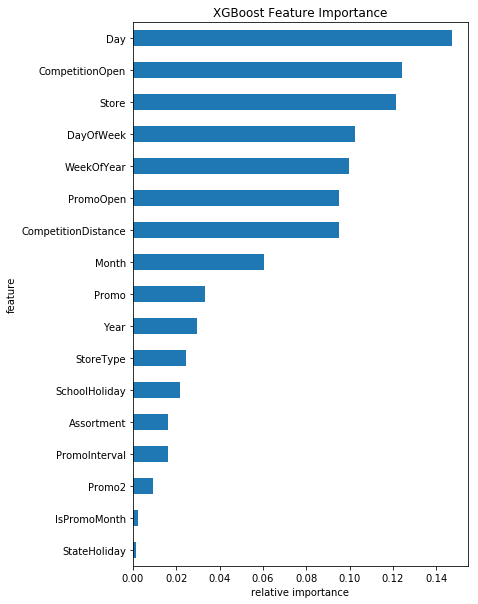

In [17]:
create_feature_map(features)
importance = gbm.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)